# Imports and intializations

* When the variable 'GeNN_backend' is set to True, the GeNN backend will be used (Brian2GeNN). It will download and set up everything needed to use it.

* GeNN speeds up the simulations significantly. However, it adds a long compilation time to the simulation. As all the cells in this notebook are just short examples, using the GeNN back end in every cell is not worth it here. 

* If you want to try Brian2GeNN, you can execute one of the cells with the GeNN backend. Just make sure you select the GPU runtime in google colab (Runtime>Change runtime tipe>GPU). However, it is recommended to switch back to the CPU runtime (Runtime>Change runtime tipe>None) and use just Brian2 to execute the below cells faster.

In [1]:
############## IMPORTS AND INITIALIZATIONS ##############

# Istall brian
!pip install brian2==2.4.2


# Imports
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np



##--- GeNN backend ---##

# If False only Brian is used. If True Brian2GeNN is used.
GeNN_backend = False  

if GeNN_backend:

  # Download GeNN
  !git clone https://github.com/genn-team/genn.git

  # Paths
  import os
  os.environ['PATH'] += ":/content/genn/bin"
  os.environ['CUDA_PATH'] = "/usr/local/cuda"

  # Install Brian2GeNN
  !pip install brian2genn==1.6

  # Activate backend
  import brian2genn
  set_device('genn')




     |████████████████████████████████| 1.2 MB 5.0 MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp37-cp37m-linux_x86_64.whl size=1257195 sha256=c4beb630e7ecded8ea4d2c0e8746252532088dcecc817d07f61e5a52de0c36fa
  Stored in directory: /root/.cache/pip/wheels/ec/f8/22/34f71a38e2efba1a88d548d18cd2a8fe35692879503e97b5f7
Successfully built brian2


In [2]:
############## FUNCTIONS ##############

def visualise_connectivity(S, title=''):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(5, 4))
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['G_in', 'G_out'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    plt.title(title)
    plt.show()


# TASK 1 - LIF with adaptive threshold

Here we use Leaky Integrate and Fire (LIF) neurons. We implement an adaptive threshold that will reduce the spiking rate of the neuron when spiking consecutively.

The threshold is defined as a dynamical system that tends to a base value. Everytime a spike occurs, the threshold is icnreased.


INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


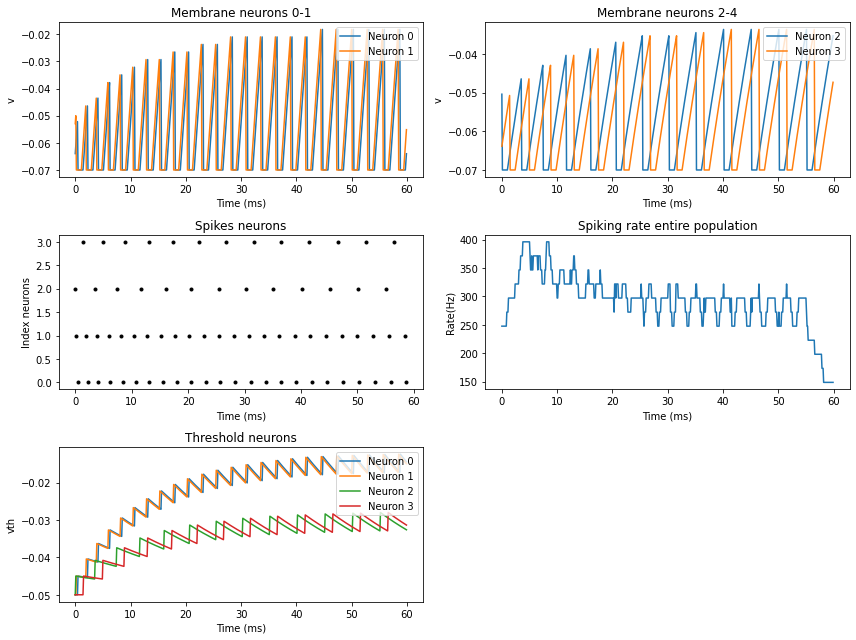

In [11]:
############## ADAPTIVE THRESHOLD ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth0 = -50*mV
vth_inc = 5*mV
tau = 20*ms
tau_th = tau*10
n_neurons = 4
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
dvth/dt = (vth0 - vth)/tau : volt
I : volt
'''
reset='''
v = vr
vth += vth_inc
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Subgroups
G1 = G[:int(n_neurons/2)]
G2 = G[int(n_neurons/2):]


# Initializations
G.v = 'vth0 + rand()*(vr-vth0)' # All neurons
G.vth = vth0
G1.I = '0.6*volt'             # First group
G2.I = '0.2*volt'             # Second group


# Monitors
monitor_vars = StateMonitor(G, ['v', 'vth'], record=True)
monitor_spk = SpikeMonitor(G)
monitor_rate = PopulationRateMonitor(G)


# Run simulation
simulation_time = 60
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,9))
plt.subplot(321)
for n in range(int(len(monitor_vars.v)/2)):
    plot(monitor_vars.t/ms, monitor_vars.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons 0-'+str(int(len(monitor_vars.v)/2)-1))
plt.legend(loc='upper right')

plt.subplot(322)
for n in range(int(len(monitor_vars.v)/2)):
    plot(monitor_vars.t/ms, monitor_vars.v[int(len(monitor_vars.v)/2)+n], label='Neuron '+str(int(len(monitor_vars.v)/2)+n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons '+str(int(len(monitor_vars.v)/2))+'-'+str(len(monitor_vars.v)))
plt.legend(loc='upper right')

plt.subplot(323)
plot(monitor_spk.t/ms, monitor_spk.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes neurons')

plt.subplot(324)
plot(monitor_rate.t/ms, monitor_rate.smooth_rate(window='flat', width=10*ms))
xlabel('Time (ms)')
ylabel('Rate(Hz)')
plt.title("Spiking rate entire population")

plt.subplot(325)
for n in range(len(monitor_vars.vth)):
    plot(monitor_vars.t/ms, monitor_vars.vth[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('vth')
plt.title('Threshold neurons')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# TASK 2 - Balance excitation and inhibition

Here we use a group of Leaky Integrate and Fire (LIF) neurons that receive spikes from two groups of spikes generators. The first group is connected by excitatory synapses. The second group is connected by inhibitory synapses.

The input neurons can spike uniformly or can be generated with a poisson distribution. While uniform trains of spike will lead to a tighter excitation/inhibition balance, poisson-generated spikes will show more biological realism.

The excitatory group contains more neurons than the inhibitory. Therefore, the total input current is positive, making the LIF neurons spike. 

Below, a rule similar to the one proposed by Vogels et al (2011) is implemented. This learning rule only modifies the inhibitory synapses strength. 



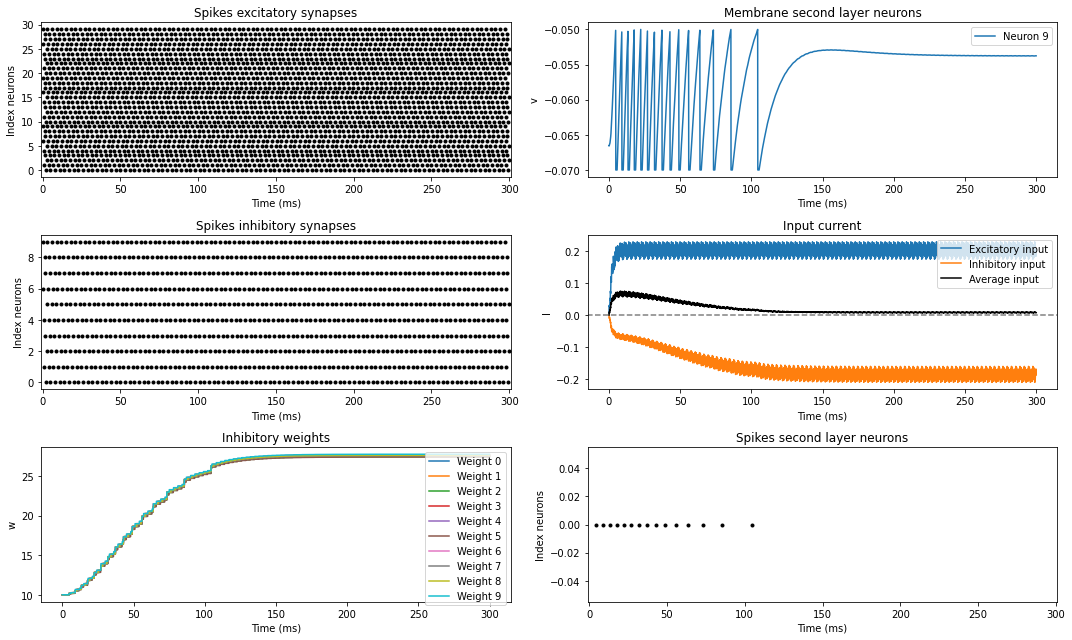

In [39]:
############## MONITORS ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
tauI = tau/10 # Much faster than the membrane potential
n_neurons_inh = 10
n_neurons_exc = n_neurons_inh*3
# spk_rate = 300*Hz
refractory = 1*ms
lr = 0.1
simulation_time = 300



##----- INPUTS UNIFORM -----##
'''
  Uncomment the lines below to use uniform spike trains. 
  The balance excitation/inhibition will be very tight, but the simulation
  will be less realistic
'''
# # Times initial spikes
# ini_inh =  np.random.uniform(low=0, high=3, size=(n_neurons_inh))
# ini_exc =  np.array([ini_inh]*3).flatten()
# # Excitatory
# G_exc = SpikeGeneratorGroup(n_neurons_exc, range(n_neurons_exc), ini_exc*ms, period = 3*ms)
# # Inhibitory
# G_inh = SpikeGeneratorGroup(n_neurons_inh, range(n_neurons_inh), ini_inh*ms, period = 3*ms)


##----- INPUTS POISSON -----##
'''
  Uncomment the lines below to use poisson spike trains. 
  The balance excitation/inhibition will be not too tight, but the simulation
  will more less realistic
'''
# Excitatory
G_exc = PoissonGroup(n_neurons_exc, spk_rate)
# Inhibitory
G_inh = PoissonGroup(n_neurons_inh, spk_rate)



##----- SECOND LAYER -----##

# Neurons population
#   *They contain an excitatory input (Ie) and inibitory input (Ii)
#   *These input currents are increased with every incoming spike
#   *These input currents decay over time (tend to 0)
eqs='''
dv/dt = (vr - v + (Ie + Ii))/tau : volt (unless refractory)
dIe/dt = -Ie/tauI : volt
dIi/dt = -Ii/tauI : volt
'''
reset='''
v = vr
'''
G_out = NeuronGroup(1, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Initializations neurons
G_out.v = 'vth + rand()*(vr-vth)'
G_out.Ie = '0*mV'
G_out.Ii = '0*mV'


# Synapses 
S_exc = Synapses(G_exc, G_out, 
                 '''
                 w : 1
                 ''',
                 on_pre='''
                 Ie_post += w*mV''',
                 on_post='''
                 ''')
                 
S_inh = Synapses(G_inh, G_out, 
                 '''
                 w : 1
                 dxpre/dt = -xpre/tau : 1
                 dxpost/dt = -xpost/tau : 1
                 ''',
                 on_pre='''
                 xpre += 1
                 Ii_post -= w*mV
                 w += lr*xpost
                 ''',
                 on_post='''
                 xpost += 1
                 w += lr*xpre
                 ''')

# Connectivity
S_exc.connect(p=1.0)
S_inh.connect(p=1.0)


# Initializations weights
S_exc.w = 10
S_inh.w = 10


# Monitors
monitor_v = StateMonitor(G_out, 'v', record=True)
monitor_w= StateMonitor(S_inh, 'w', record=True)
monitor_I = StateMonitor(G_out, ['Ie', 'Ii'], record=True)
monitor_spk_in1 = SpikeMonitor(G_exc)
monitor_spk_in2 = SpikeMonitor(G_inh)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
run(simulation_time*ms)



# Visualizations
plt.figure(figsize=(15,9))
plt.subplot(321)
plot(monitor_spk_in1.t/ms, monitor_spk_in1.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes excitatory synapses')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(322)
plot(monitor_v.t/ms, monitor_v.v[0], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Membrane second layer neurons')

plt.subplot(323)
plot(monitor_spk_in2.t/ms, monitor_spk_in2.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes inhibitory synapses')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(324)
plot(monitor_v.t/ms, monitor_I.Ie[0], label='Excitatory input')
plot(monitor_v.t/ms, monitor_I.Ii[0], label='Inhibitory input')
plot(monitor_v.t/ms, np.mean([monitor_I.Ie[0], monitor_I.Ii[0]], axis=0), label='Average input', color='black')
xlabel('Time (ms)')
ylabel('I')
plt.legend(loc='upper right')
plt.title('Input current')
plt.axhline(y=0, xmin=-1, xmax=simulation_time+1, color='gray', linestyle='--')

plt.subplot(325)
for n in range(len(monitor_w.w)):
  plot(monitor_w.t/ms, monitor_w.w[n], label='Weight '+str(n))
xlabel('Time (ms)')
ylabel('w')
plt.legend(loc='upper right')
plt.title('Inhibitory weights')

plt.subplot(326)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes second layer neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()

